# Reconstruction Analysis True Hits (RATH) : Analysis 
- Analysis of the output of the Reconstruction Analysis for True hits (RATH).
- Loads from disk
- Plot Statistics
- GraphTracks manipulation
    - GraphTracks are constructed from the EventTrack object, and are used to define blobs and find blob energy. 
- Visualisation of events where single and multiple tracks where reconstructed in $\beta\beta0\nu$ events.

## Voxel bin = 5, contiguity = 10, r = 5

##### General

In [566]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [567]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
import functools
import time

from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import networkx as nx
from itertools   import combinations

In [568]:
from pandas import DataFrame, Series
from typing import List, Tuple
from typing import Union
from   dataclasses import dataclass

In [569]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [570]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

##### IC

In [571]:

import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


##### TICs

In [572]:
from tics.histograms    import h1
from tics.pd_tics       import get_index_slice_from_multi_index
from tics.pd_tics   import slice_and_select_df
from tics.graphics_reco import plot_hits3d
from tics.stats_tics    import bin_data_with_equal_bin_size
from tics.util_tics import get_class_name
from tics.util_tics import Range
from tics.graphics_reco import plot_gtrack
from tics.system_of_units import *

##### NetFlex

In [573]:
from nextflex.core import Setup

In [574]:
from nextflex.core import Setup
from nextflex.mctrue_functions import get_mc_particles
from nextflex.mctrue_functions import get_mc_primary_particles
from nextflex.mctrue_functions import get_mc_vertex
from nextflex.mctrue_functions import select_mc_particles
from nextflex.mctrue_functions import get_mc_hits
from nextflex.mctrue_functions import select_mc_hits
from nextflex.mctrue_functions import total_hit_energy
from nextflex.mctrue_functions import get_event_hits_from_mchits

In [575]:
from nextflex.reco_functions import voxelize_hits
from nextflex.reco_functions import get_voxels_as_list
from nextflex.reco_functions import voxel_position
from nextflex.reco_functions import voxel_energy
from nextflex.reco_functions import voxel_nhits
from nextflex.reco_functions import distance_between_two_voxels
from nextflex.reco_functions import voxel_distances
from nextflex.reco_functions import voxel_distance_pairs
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import gtrack_voxels
from nextflex.reco_functions import shortest_paths
from nextflex.reco_functions import find_extrema_and_length
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import GTracks
from nextflex.reco_functions import voxels_in_blob
from nextflex.reco_functions import blob_energy


In [576]:
from nextflex.io import write_event_gtracks_json
from nextflex.io import load_event_gtracks_json
from nextflex.io import save_to_JSON
from nextflex.io import load_from_JSON

In [577]:
from nextflex.reco_analysis import reco_gtrack_from_mc_hits
from nextflex.reco_analysis import reco_gtrack_blobs
from nextflex.reco_analysis import TrackRecoStats
from nextflex.reco_analysis import TrackRecoTiming
from nextflex.reco_analysis import TrackRecoEventStats
from nextflex.reco_analysis import GtrkStats
from nextflex.reco_analysis import gtrack_summary
from nextflex.reco_analysis import select_gtrack_topology
from nextflex.reco_analysis import distance_between_extrema
from nextflex.reco_analysis import gtrack_df
from nextflex.reco_analysis import event_list_by_multiplicity
from nextflex.reco_analysis import tExtrema_df
from nextflex.reco_analysis import RecoGtrackFromMcHits

In [578]:
from nextflex.analysis_histos import reco_gtrack_stats_histos
from nextflex.analysis_histos import reco_gtrack_timing_histos
from nextflex.analysis_histos import reco_gtrack_blobs_histos
from nextflex.analysis_histos import plot_complexity
from nextflex.analysis_graphics import plot_single_tracks_list
from nextflex.analysis_graphics import plot_multiple_tracks_list

In [579]:
from nextflex.types import EventHits
from nextflex.types import VoxelHits


In [580]:
from nextflex.analysis_blobs import blob_energy
from nextflex.analysis_blobs import select_topology_and_energy
from nextflex.analysis_blobs import select_blobs_eff_energy
from nextflex.analysis_blobs import select_blobs
from nextflex.analysis_blobs import energy_resolution
from nextflex.analysis_blobs import selection_efficiency
from nextflex.analysis_blobs import distance_reco_true
from nextflex.analysis_blobs import d12_eff
from nextflex.analysis_blobs import selection_efficiency_blob
from nextflex.analysis_blobs import select_distance_cut

## Input data

In [581]:
FDATA = os.environ['FLEXDATA']

##### bb0nu

In [582]:
setbb = Setup(flexDATA = FDATA,
              tpConfig = "FLEX100_M6_O6.EL8bar.bb0nu")
print(setbb)


        Setup <FLEX100_M6_O6.EL8bar.bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6.EL8bar.bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/FLEX100_M6_O6.EL8bar.bb0nu
        analysis directory           = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6.EL8bar.bb0nu
        number of h5 files in dir    = 621
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6.EL8bar.bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.cs

##### single electrons

In [583]:
set1e = Setup(flexDATA = FDATA,
              tpConfig = "FLEX100_M6_O6.EL8bar.1e")
print(set1e)


        Setup <FLEX100_M6_O6.EL8bar.1e_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6.EL8bar.1e
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/FLEX100_M6_O6.EL8bar.1e
        analysis directory           = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6.EL8bar.1e
        number of h5 files in dir    = 613
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6.EL8bar.1e_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv
        


## Analysis

In [584]:
voxel_bin  = 5
contiguity = 10

### Create a new instance and load from disk

In [585]:
rbb = RecoGtrackFromMcHits(setbb, voxel_bin, contiguity)
rbb.load_setup()

In [586]:
r1e = RecoGtrackFromMcHits(set1e, voxel_bin, contiguity)
r1e.load_setup()

### Statistics

#### Reco Event Statistics

##### bb

In [587]:
rbb.trackRecoEventStats


        <Track Reconstruction Statistics>
        size of voxel bins          = 5
        contiguity parameter        = 10
        topology                    = all
        event type                  = bb0nu
        voxels from hits barycenter = True
        number of files analyzed    = 620
        number of events analyized  = 2668
        number of events 1 GT       = 1750
        

##### 1e

In [588]:
r1e.trackRecoEventStats


        <Track Reconstruction Statistics>
        size of voxel bins          = 5
        contiguity parameter        = 10
        topology                    = all
        event type                  = 1e
        voxels from hits barycenter = True
        number of files analyzed    = 612
        number of events analyized  = 2492
        number of events 1 GT       = 1650
        

In [589]:
total_events_bb = rbb.trackRecoEventStats.e_total
total_events_1e = r1e.trackRecoEventStats.e_total
single_track_bb = rbb.trackRecoEventStats.e_gt
single_track_1e = r1e.trackRecoEventStats.e_gt
single_track_eff_bb = single_track_bb / total_events_bb
single_track_eff_1e = single_track_1e / total_events_1e

print(f"""
total events bb = {total_events_bb}, total events 1e = {total_events_1e}
single track bb = {single_track_bb}, single track 1e = {single_track_1e}
single track eff bb = {single_track_eff_bb:5.2f} 
single track eff 1e = {single_track_eff_1e:5.2f}
""")


total events bb = 2668, total events 1e = 2492
single track bb = 1750, single track 1e = 1650
single track eff bb =  0.66 
single track eff 1e =  0.66



#### Complexity

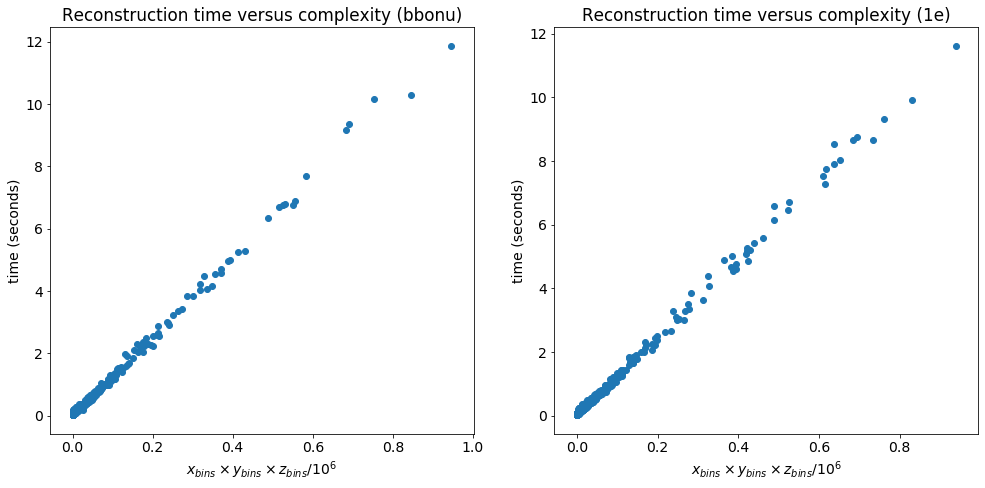

In [590]:
plot_complexity(rbb, r1e, figsize=(14,7))

#### Reco GTracks

##### bb0nu

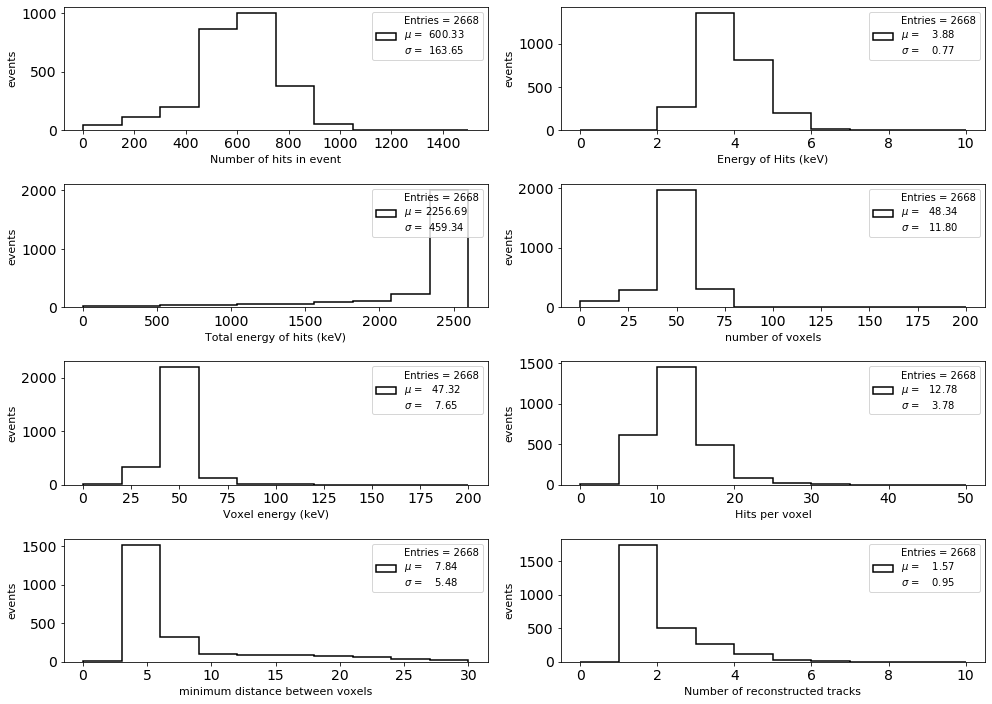

In [591]:
reco_gtrack_stats_histos(rbb.trackRecoStats, 
                         energy_evt_hits = (0,10),  
                         n_voxels        = (0,200),
                         energy_voxels   = (0,200),
                         n_hits_voxels   = (0,50),
                         min_dist_voxels = (0,30),
                         figsize=(14,10))

##### 1e

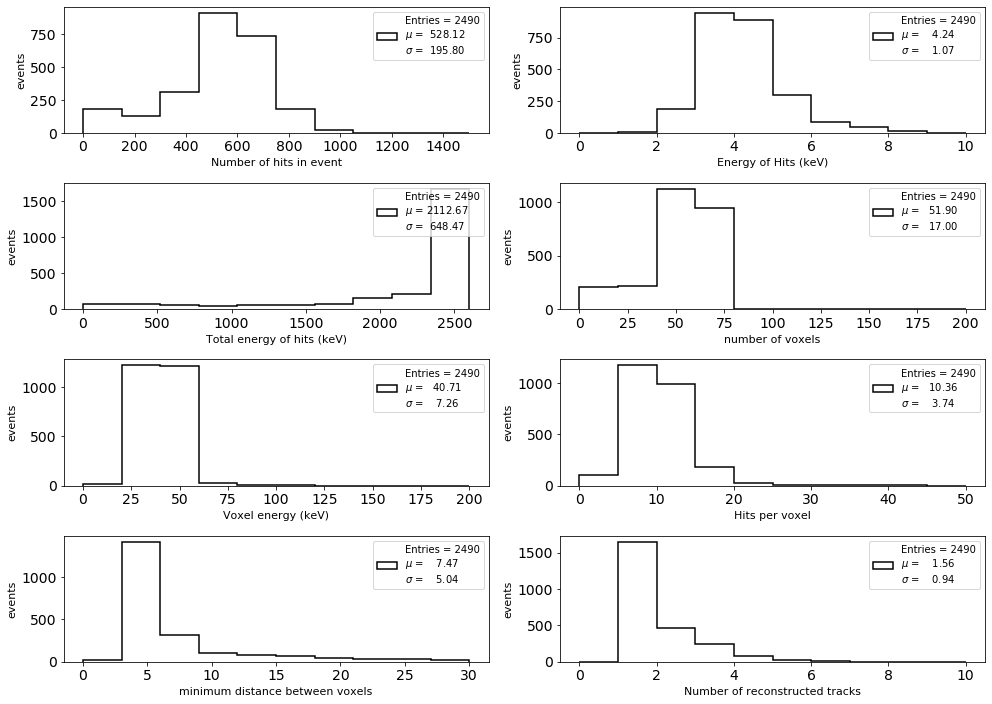

In [592]:
reco_gtrack_stats_histos(r1e.trackRecoStats, 
                         energy_evt_hits = (0,10),  
                         n_voxels        = (0,200),
                         energy_voxels   = (0,200),
                         n_hits_voxels   = (0,50),
                         min_dist_voxels = (0,30),
                         figsize=(14,10))

- Notice that the number of reconstructed tracks in bb0nu and single electrons have the same distributions (in fact all distributions are very similar) which shows that selecting more than one track does not help (increases signal and background in the same proportion)

#### Timing

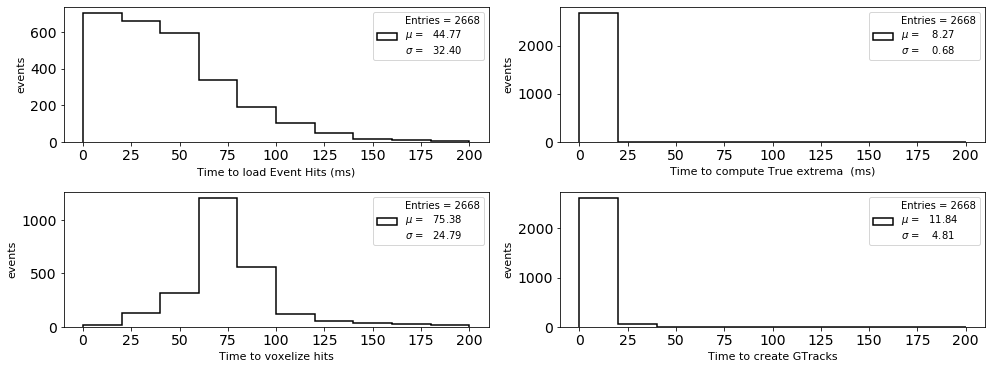

In [593]:
reco_gtrack_timing_histos(rbb.trackRecoTiming, 
                          t_voxelize_hits  = (0,200),
                          figsize=(14,10))

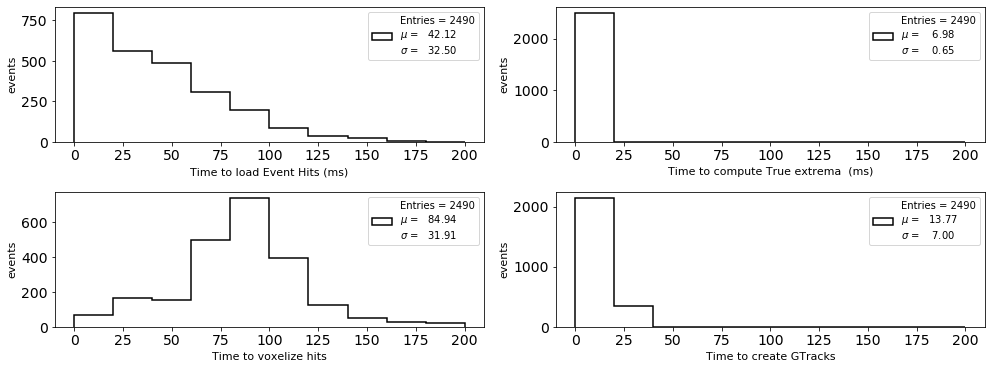

In [594]:
reco_gtrack_timing_histos(r1e.trackRecoTiming, 
                          t_voxelize_hits  = (0,200),
                          figsize=(14,10))

Reconstructing single electrons takes a bit longer (81 ms vs 71 ms) than reconstructing bb0nu which suggests that electron tracks may be a bit longer (less convoluted than bb0nu double electrons)

### Graph Tracks and True Extrema

- The radius of the blob is taken as having the same size of the voxelisation. This is a parameter which can be varied for optimisation

In [595]:
rb = 5

#### bb0nu

##### bb0nu

In [596]:
gtbb = gtrack_df(rbb.gtracks, rb)

In [597]:
gtbb.head()

event_id  track_id  n_voxels  trak_length       energy  \
evt_number trk_number                                                           
0          0                212         0        47   128.388471  2267.494424   
           1                212         1         1     0.000000    12.581009   
           2                212         2         1     0.000000    29.781301   
           3                212         3         1     0.000000   132.281467   
1          0                213         0        61   137.483020  2439.155334   

                             x_e1        y_e1        z_e1  energy_e1  nvox_b1  \
evt_number trk_number                                                           
0          0          -161.863903 -410.403261  799.438663   0.209614        2   
           1          -154.306005 -210.879696  907.142098   0.012581        1   
           2          -110.534864 -155.678515  899.274488   0.029781        1   
           3          -107.638045 -171.495649  902.835057   0.132281        1   
1          0          -242.520752  283.138306  717.443176   0.007230        3   

                        energy_b1        x_e2        y_e2        z_e2  \
evt_number trk_number                                                   
0          0           236.709647 -114.430321 -433.747009  787.070068   
           1            12.581009 -154.306005 -210.879696  907.142098   
           2            29.781301 -110.534864 -155.678515  899.274488   
           3           132.281467 -107.638045 -171.495649  902.835057   
1          0            94.601179 -227.169733  278.949920  649.013203   

                       energy_e2  nvox_b2   energy_b2  
evt_number trk_number                                  
0          0            0.048411        4  335.771788  
           1            0.012581        1   12.581009  
           2            0.029781        1   29.781301  
           3            0.132281        1  132.281467  
1          0            0.104347        4  308.899343

##### Select the topology of single tracks

In [598]:
g1tbb = select_gtrack_topology(gtbb, topology = "single")

In [599]:
print(f"efficiency, single track topology = {len(g1tbb) / total_events_bb}")

efficiency, single track topology = 0.6559220389805097


In [600]:
g1tbb.head()

,,event_id,track_id,n_voxels,trak_length,energy,x_e1,y_e1,z_e1,energy_e1,nvox_b1,energy_b1,x_e2,y_e2,z_e2,energy_e2,nvox_b2,energy_b2
evt_number,trk_number,,,,,,,,,,,,,,,,,
1,0,213,0,61,137.483020,2439.155334,-242.520752,283.138306,717.443176,0.007230,3,94.601179,-227.169733,278.949920,649.013203,0.104347,4,308.899343
2,0,214,0,66,144.530775,2437.588115,-140.786118,-67.971995,102.311765,0.557772,2,563.045236,-116.036812,-47.284351,63.788048,0.075812,2,83.126468
3,0,215,0,51,67.810160,2438.890893,-361.351823,-288.980607,1079.417748,0.045966,2,129.653264,-333.010227,-315.316369,1047.702655,0.045498,2,74.647058
4,0,172,0,52,111.580567,2435.026482,-214.966620,-344.326786,530.984315,0.253511,1,253.511310,-186.550120,-325.893345,553.496637,0.016075,3,82.414331
5,0,173,0,51,135.811184,2440.788670,166.666516,102.179322,537.737975,0.288776,2,396.491684,176.569347,158.746735,474.481641,0.230331,2,299.556769


##### Histograms for single track topology

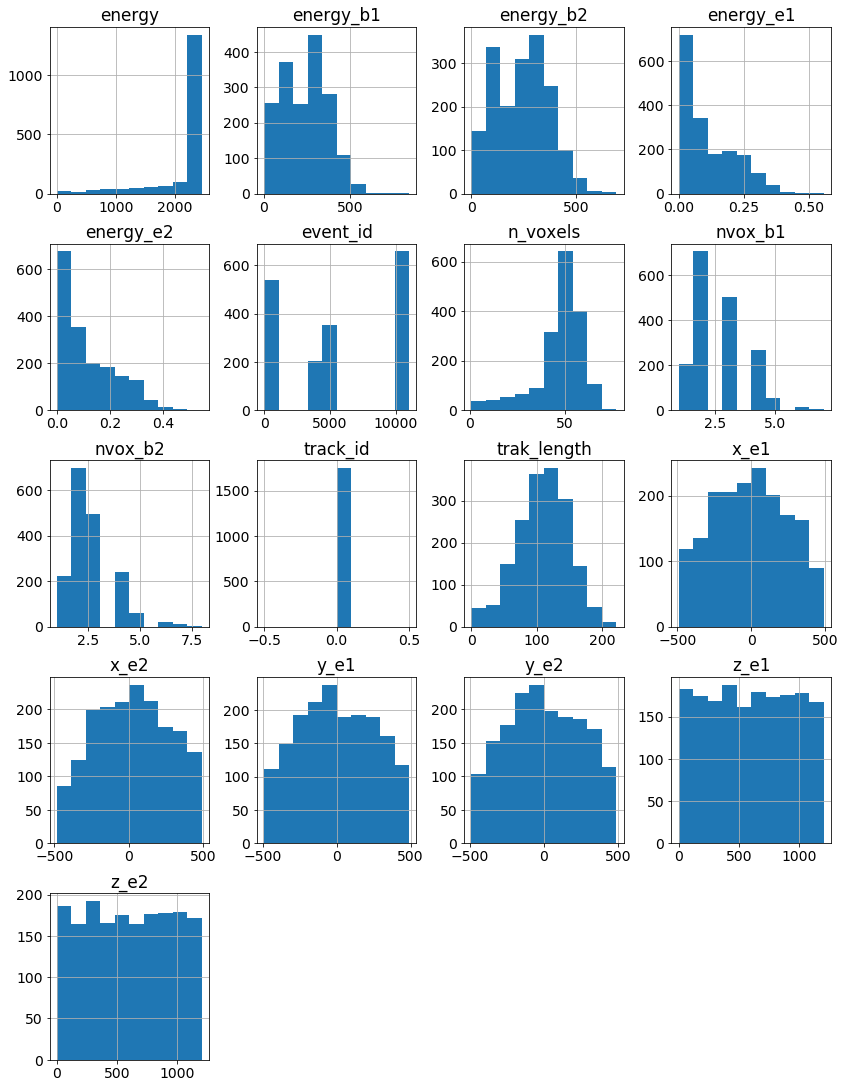

In [601]:
hist = g1tbb.hist(figsize = (14,19))

##### Energy blob1 vs blob2

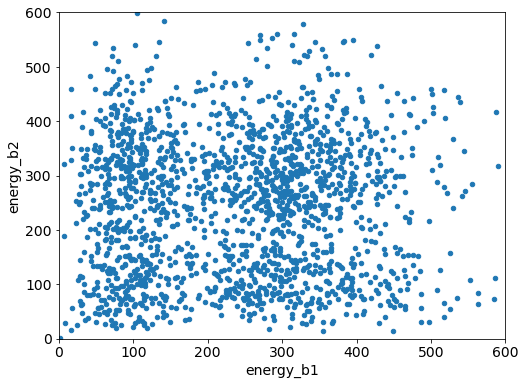

In [603]:
ax1 = g1tbb.plot.scatter(x='energy_b1', y='energy_b2')
ax1.set_xlim([0,600])
ax1.set_ylim([0,600])
plt.show()

#### 1e

In [604]:
gt1e = gtrack_df(r1e.gtracks, rb)

In [605]:
g1t1e = select_gtrack_topology(gt1e, topology = "single")

In [606]:
print(f"efficiency, single track topology = {len(g1t1e) / total_events_1e}")

efficiency, single track topology = 0.6621187800963082


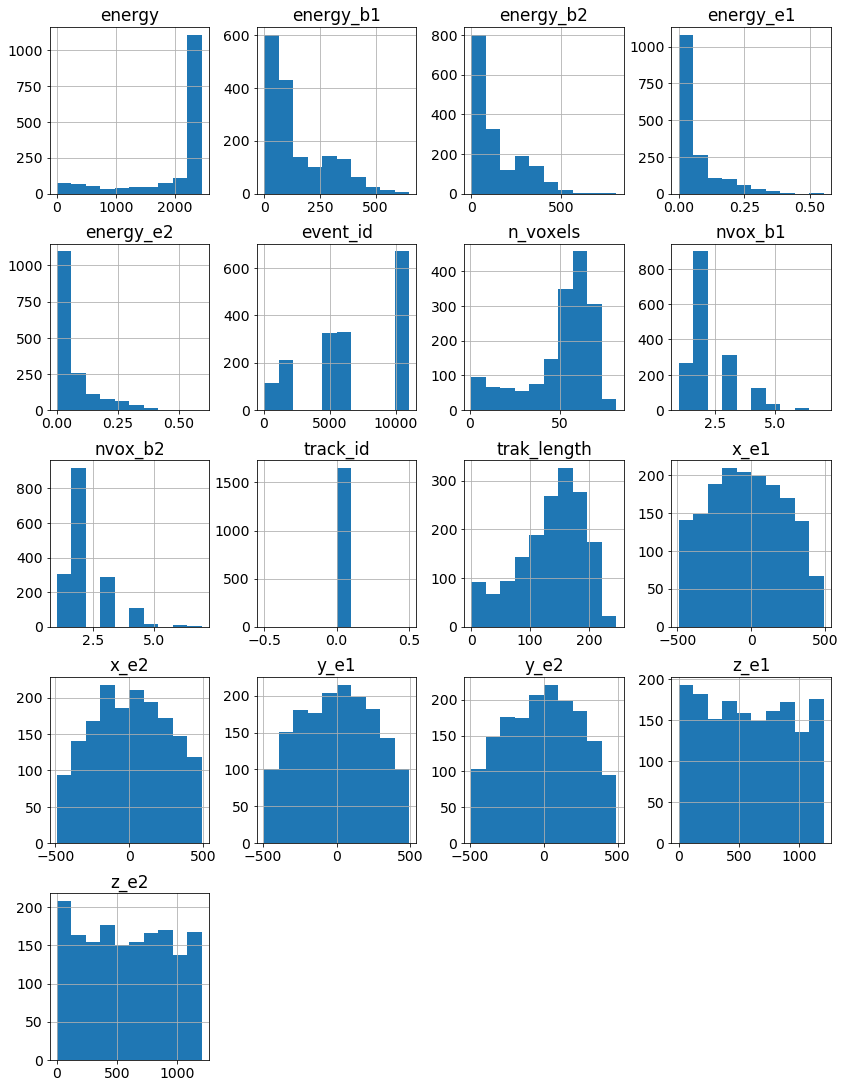

In [607]:
hist = g1t1e.hist(figsize = (14,19))

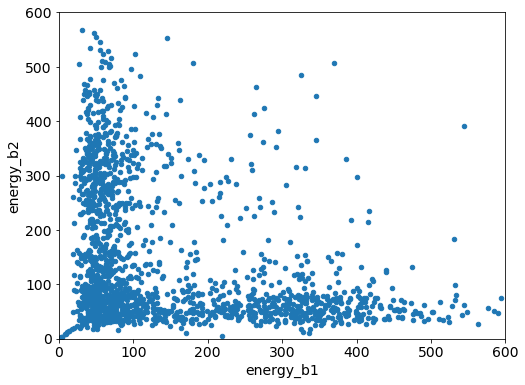

In [609]:
ax1 = g1t1e.plot.scatter(x='energy_b1', y='energy_b2')
ax1.set_xlim([0,600])
ax1.set_ylim([0,600])
plt.show()

### Blob analysis

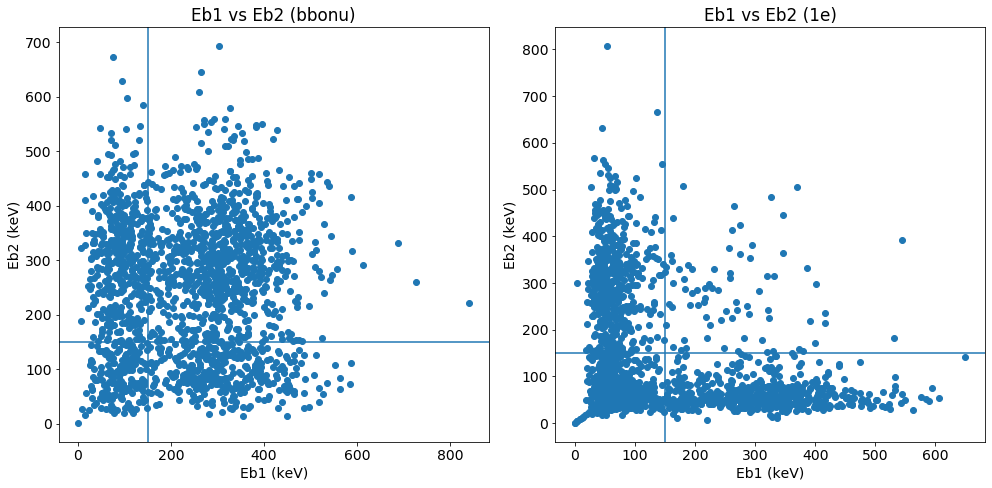

In [610]:
blob_energy(g1tbb, g1t1e, eb_cut=150, figsize=(14,7))

In [611]:
fbb, f1e = select_topology_and_energy(gtbb,gt1e, energy_range=(2400, 2500))

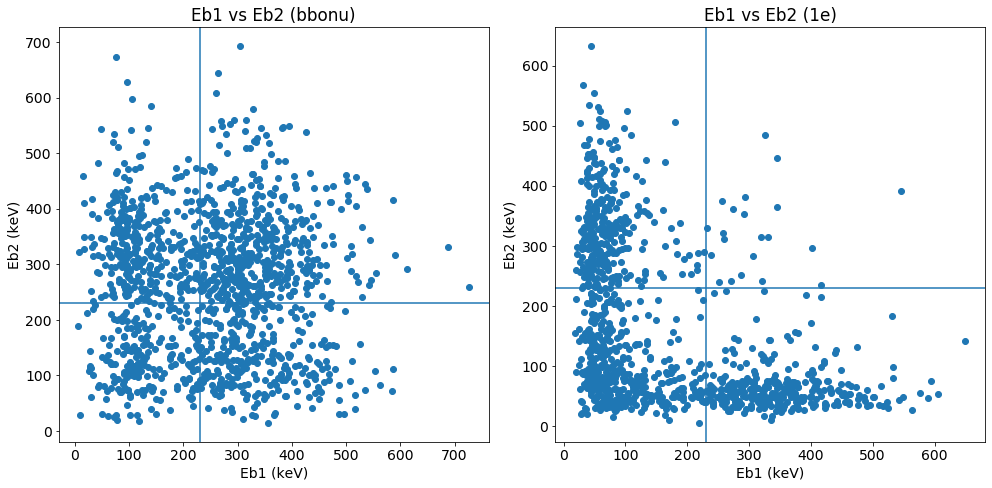

In [616]:
blob_energy(fbb, f1e, eb_cut=230, figsize=(14,7))

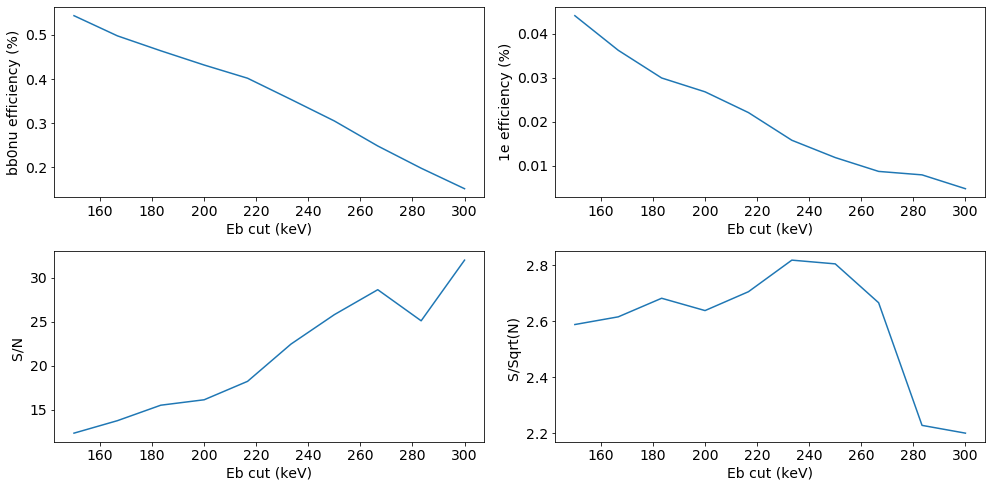

In [614]:
select_blobs_eff_energy(rbb, fbb, f1e, figsize=(14,7))

In [617]:
selection_efficiency(rbb, gtbb, energy_range=(2400, 2500), eb_cut=230)

Selection efficiency:
- single track topology  = 0.6559220389805097
- energy cut             = 0.7257142857142858
- 2-blob cut             = 0.36220472440944884
- total efficiency       = 0.1724137931034483


In [618]:
selection_efficiency(r1e, gt1e, energy_range=(2400, 2500), eb_cut=230)

Selection efficiency:
- single track topology  = 0.6621187800963082
- energy cut             = 0.6284848484848485
- 2-blob cut             = 0.020250723240115717
- total efficiency       = 0.008426966292134831


In [619]:
print(f"suppression factor 2-blob = {0.36/0.02:5.2e}")

suppression factor 2-blob = 1.80e+01


### True extrema analysis

#### Get (sorted) true Extrema dataframes

In [620]:
rbbtE = rbb.tExtrema.sort_values(by=['evt_number'])

In [621]:
r1etE = r1e.tExtrema.sort_values(by=['evt_number'])

In [622]:
rbbtE.head()

,evt_number,extreme_number,x,y,z,time,energy
2325,0,1,-261.039703,-230.863617,792.874023,0.523512,2.868718
2324,0,0,-273.207062,-255.572342,724.871460,0.348872,1.072744
2327,1,1,193.813828,-268.276672,269.610596,0.297654,1.984057
2326,1,0,142.678940,-234.377289,313.767792,0.545446,1.649472
2329,2,1,119.082611,-456.185028,827.313965,0.610715,3.235260


In [623]:
r1etE.head()

,evt_number,extreme_number,x,y,z,time,energy
3248,40,0,-128.768143,427.334961,476.508148,0.003298,44.649459
3249,40,1,-166.702469,421.212341,529.789001,0.528587,3.888908
3250,41,0,332.175476,-148.522003,737.123474,0.003366,11.620134
3251,41,1,297.396545,-234.403412,735.747742,0.756642,1.734917
3252,42,0,76.672745,-481.613525,275.678589,0.003386,4.068275


#### Get (sorted) dataframes for fiducially selected bb and 1e events

In [624]:
sfbb = fbb.sort_values(by=['event_id']).reset_index(level='trk_number', drop=True).\
drop(columns=['track_id'])

In [625]:
sfbb.head()

,event_id,n_voxels,trak_length,energy,x_e1,y_e1,z_e1,energy_e1,nvox_b1,energy_b1,x_e2,y_e2,z_e2,energy_e2,nvox_b2,energy_b2
evt_number,,,,,,,,,,,,,,,,
1162,0,44,134.509714,2434.332104,-273.285074,-256.416805,727.969068,0.025585,2,332.224313,-261.722840,-228.844988,792.806108,0.018397,3,239.837991
1163,1,55,149.103735,2435.044601,148.914096,-234.920804,314.669606,0.009803,4,158.192509,194.789836,-267.874779,269.921236,0.227454,1,227.454424
1164,2,57,127.194354,2439.964902,126.759245,-453.950754,814.810151,0.063756,4,195.709988,182.151383,-423.539424,826.154673,0.018763,4,338.929271
1165,3,48,48.472756,2441.591172,359.428336,101.720835,980.357658,0.025286,3,141.862568,375.266391,73.480364,990.419728,0.012201,5,71.460769
698,5,46,102.161347,2446.390524,-269.327212,-200.576211,868.355583,0.055446,3,339.610837,-229.218065,-216.894856,925.735200,0.191238,3,453.529323


In [626]:
sf1e = f1e.sort_values(by=['event_id']).reset_index(level='trk_number', drop=True).\
drop(columns=['track_id'])

In [627]:
sf1e.head()

,event_id,n_voxels,trak_length,energy,x_e1,y_e1,z_e1,energy_e1,nvox_b1,energy_b1,x_e2,y_e2,z_e2,energy_e2,nvox_b2,energy_b2
evt_number,,,,,,,,,,,,,,,,
1611,43,56,187.277898,2446.977308,-377.365538,6.907143,791.618311,0.159828,2,260.956183,-332.614115,-56.164273,772.350334,0.041688,2,49.228380
1612,44,75,198.655272,2427.471578,-167.854187,143.703522,365.851349,0.007046,3,49.167881,-134.142282,234.645527,439.488991,0.324971,3,390.640574
1985,70,53,146.272219,2443.038419,112.251000,390.009636,904.400477,0.262202,1,262.201756,170.583261,312.498572,899.910035,0.082135,2,225.271516
1986,71,73,220.600610,2440.492847,20.731323,-335.107776,343.055124,0.011293,2,29.771343,29.995705,-314.374500,414.720072,0.043100,2,294.467144
1988,73,61,190.185600,2439.084752,223.091081,29.616246,979.612344,0.038998,2,99.138353,237.650212,61.536201,941.913084,0.021364,3,347.443860


#### Compute a dataframe of distances 
- d1 (d2) are defined as the closest distance between an extreme and a reconstructed extreme

##### for bb0nu

In [628]:
dfbbTE= distance_reco_true(sfbb, rbbtE, event_range=(0,-1))

In [629]:
dfbbTE.head()

,event_id,d1,d2
0,0,3.211601,2.132170
1,1,6.323437,1.100276
2,2,14.841430,4.796286
3,3,20.608307,19.859722
4,5,14.190914,0.477698


##### For 1e

In [630]:
df1eTE= distance_reco_true(sf1e, r1etE, event_range=(0,-1))

In [631]:
df1eTE.head()

,event_id,d1,d2
0,43,0.682445,2.967213
1,44,0.999969,1.918061
2,70,0.779412,4.578029
3,71,1.636257,0.971621
4,73,1.925507,4.180891


##### Plot results

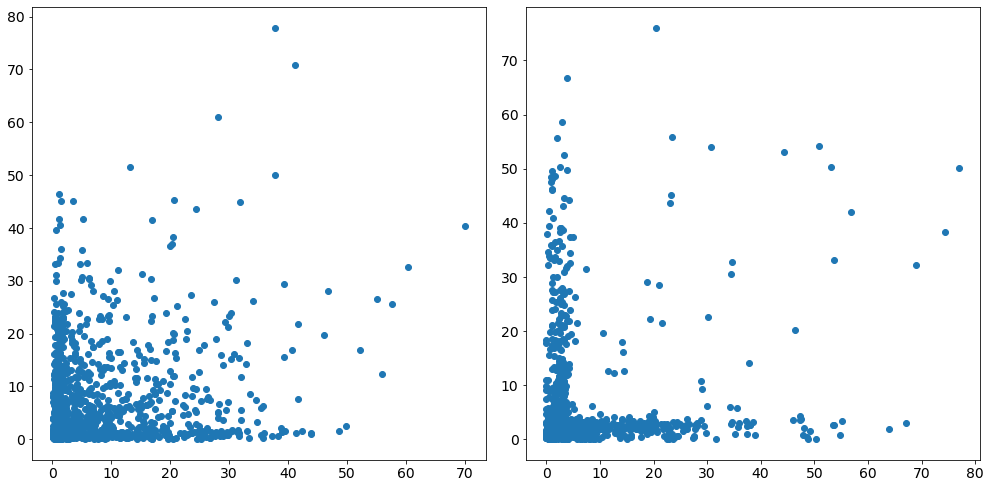

In [632]:
fig = plt.figure(figsize=(14,7))
ax  = fig.add_subplot(1, 2, 1)
plt.scatter(dfbbTE.d1, dfbbTE.d2)
ax1.set_xlim([0,50])
ax1.set_ylim([0,50])
ax  = fig.add_subplot(1, 2, 2)

plt.scatter(df1eTE.d1, df1eTE.d2)
ax1.set_xlim([0,50])
ax1.set_ylim([0,50])
plt.tight_layout()
plt.show()

##### Distance between reconstructed and true blob is o the order of the voxelisation, but spread can be large, leading to missidentification.

#### Fraction of events as a function of the distance between reconstructed and true extrema

In [633]:
d, xbb = d12_eff(dfbbTE, d_range = (0,50), figsize=(10,6))

In [634]:
d, x1e = d12_eff(df1eTE, d_range = (0,50), figsize=(10,6))

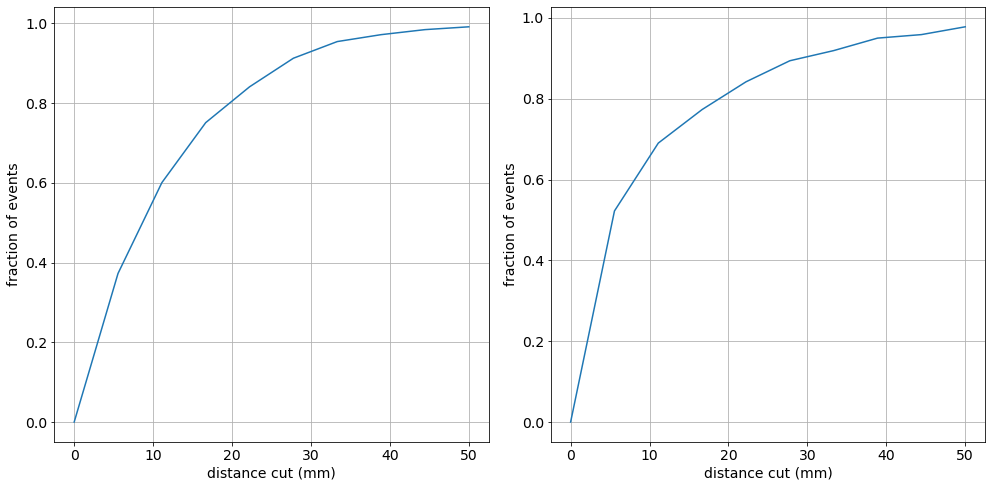

In [635]:
fig = plt.figure(figsize=(14,7))
ax  = fig.add_subplot(1, 2, 1)
plt.plot(d, xbb)
plt.xlabel("distance cut (mm)")
plt.ylabel("fraction of events")
plt.grid()
ax  = fig.add_subplot(1, 2, 2)
plt.plot(d, x1e)
plt.xlabel("distance cut (mm)")
plt.ylabel("fraction of events")
plt.grid()
plt.tight_layout()
plt.show()

### Selection efficiency when limiting distance (true-reco)

- According to the results that we have found, the selection efficiency for bb0nu should increase and the relative background for 1e should decrease as we make tighter cuts in the distance allowed between reconstructed and true extrema.

- Notice that this is not a "realistic cut" but instead a way to illustrate the limits of the algorithm.

#### |d_r - d_true | < 5 mm

##### For bb

In [647]:
events_ddf_bb = select_distance_cut(dfbbTE, sfbb, dcut=5)

In [648]:
sfbbx = sfbb[np.in1d(sfbb.event_id.values, events_ddf_bb)]

In [649]:
selection_efficiency_blob(fbb, eb_cut=230)

- 2-blob cut efficiency    = 0.36220472440944884


In [650]:
selection_efficiency_blob(sfbbx, eb_cut=230)

- 2-blob cut efficiency    = 0.8125


##### For 1e

In [651]:
events_ddf_1e = select_distance_cut(df1eTE, sf1e, dcut=5)

In [652]:
sf1ex = sf1e[np.in1d(sf1e.event_id.values, events_ddf_1e)]

In [653]:
selection_efficiency_blob(f1e, eb_cut=230)

- 2-blob cut efficiency    = 0.020250723240115717


In [654]:
selection_efficiency_blob(sf1ex, eb_cut=230)

- 2-blob cut efficiency    = 0.015655577299412915


##### Reconstruction result
- Notice that events reconstructed with energy less than cut (230) keV are source of inefficiency for the signal, which increases dramatically with the condition, and also helps background. 

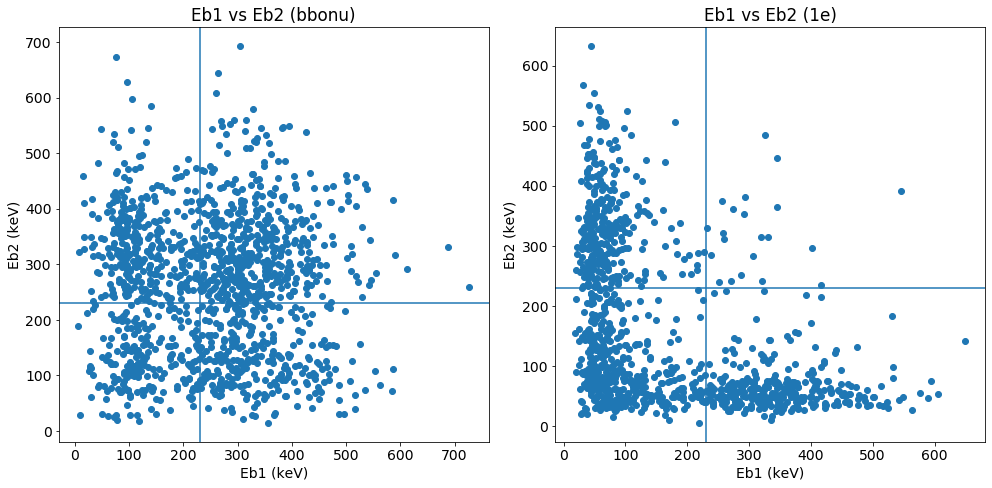

In [655]:
blob_energy(fbb, f1e, eb_cut=230, figsize=(14,7))

##### Reconstruction result imposing | d_r - d_true | < 5 mm
- Notice that events with low energy dissappear, increasing the efficiency o the signal, and the fraction of background events also improves a little. However, such fraction appears to be related with adding too much energy in the blob (even when the reconstructed end voxel is within 10 mm of the true voxel

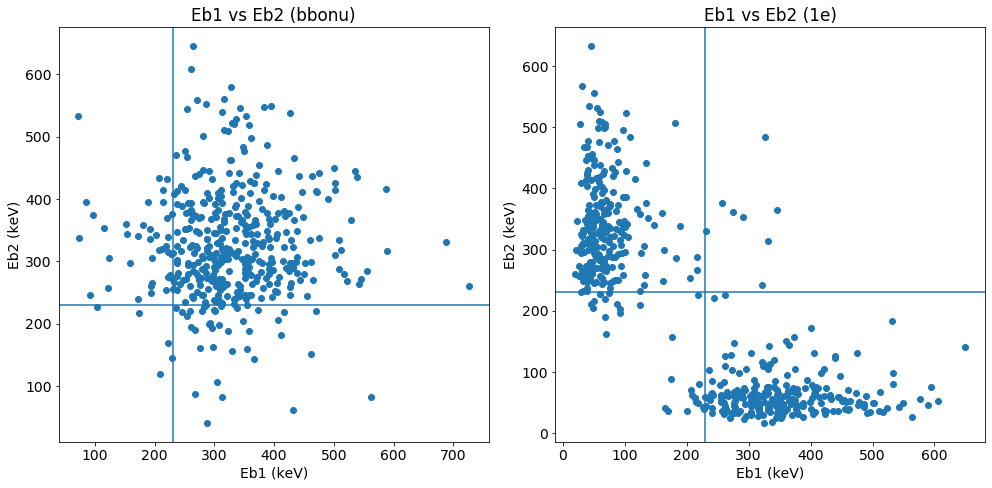

In [656]:
blob_energy(sfbbx, sf1ex, eb_cut=230, figsize=(14,7))

Tightening the distance does not change much the efficiency for signal but improves background rejection 

### Effect of blob radius

##### Consider the case of a blob radius of the size of contiguity 

In [657]:
rb = 10

In [658]:
gtbb = gtrack_df(rbb.gtracks, rb)
gt1e = gtrack_df(r1e.gtracks, rb)

In [659]:
fbb, f1e = select_topology_and_energy(gtbb,gt1e, energy_range=(2400, 2500))

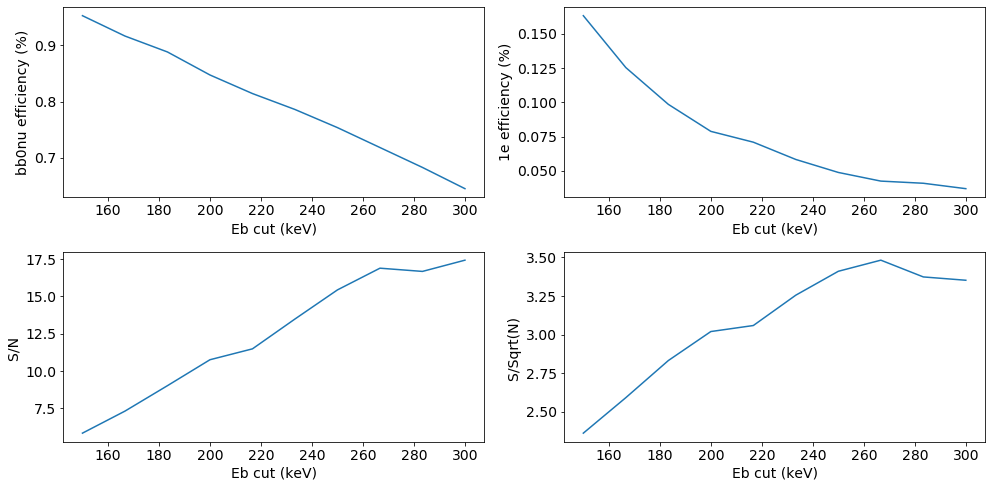

In [660]:
select_blobs_eff_energy(rbb, fbb, f1e, figsize=(14,7))

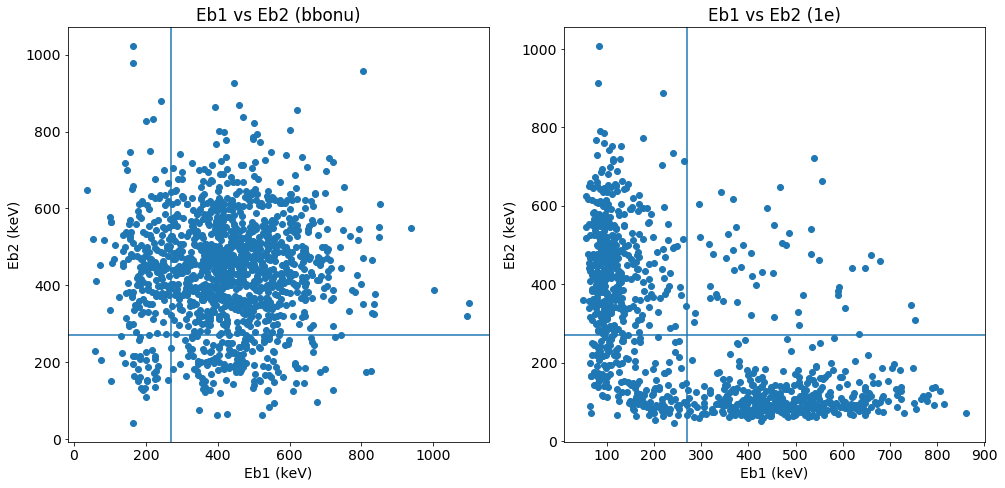

In [665]:
blob_energy(fbb, f1e, eb_cut=270, figsize=(14,7))

In [666]:
selection_efficiency(rbb, gtbb, energy_range=(2400, 2500), eb_cut=270)

Selection efficiency:
- single track topology  = 0.6559220389805097
- energy cut             = 0.7257142857142858
- 2-blob cut             = 0.7094488188976378
- total efficiency       = 0.3377061469265367


In [667]:
selection_efficiency(r1e, gt1e, energy_range=(2400, 2500), eb_cut=270)

Selection efficiency:
- single track topology  = 0.6621187800963082
- energy cut             = 0.6284848484848485
- 2-blob cut             = 0.05110896817743491
- total efficiency       = 0.02126805778491172


In [668]:
print(f"suppression factor 2-blob = {0.7/0.05:5.2e}")

suppression factor 2-blob = 1.40e+01


- Increasing the radius multiplies x 2 the efficiency of the signal but by 2.5 the efficiency of the background.
- S/N optimises at values of rather small efficiency for the signal. 

### Conclussions
- Voxel size determines the granularity of the algorithm. 
- Blob radius should be of the order of the voxel size
- Contiguity should be between 1.5 and 2 times the size of the voxel
- Signal efficiency is determined by errors integrating (e.g, missed true extrema)
- Background is determined by errors integrating (integrated too much charge in the wrong blob)
- S/N optimises in values of relatively low efficiency for the signal.